In [33]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

In [34]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Appying the mask to ssh_hf_1h, keep data where mask is equal to 1
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

In [35]:
# Setup the UTM projection (if not already done)
proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')
lat = ssh_hf_1h['lat'].values
lon = ssh_hf_1h['lon'].values
x, y = np.vectorize(proj)(lon, lat)

# Convert coordinates from meters to kilometers
x_km = x / 1000
y_km = y / 1000

# Integrate UTM coordinates (in kilometers) into the dataset
ssh_hf_1h_masked = ssh_hf_1h_masked.assign_coords({"utm_x": (("y", "x"), x_km), "utm_y": (("y", "x"), y_km)})

In [36]:
ssh_hf_1h_masked

<xarray.DataArray 'ssh_hf' (y: 853, x: 788)> Size: 5MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.46211706, -0.46209282, ...,  0.12072774,
         0.12077472,         nan],
       [        nan, -0.46215664, -0.4621357 , ...,  0.12070754,
         0.12075365,         nan],
       ...,
       [        nan, -0.28550266, -0.28544754, ...,  0.33252342,
         0.33249071,         nan],
       [        nan, -0.28555795, -0.28550192, ...,  0.33252699,
         0.33249866,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    lat      (y, x) float32 3MB -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (y, x) float32 3MB 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
    utm_x    (y, x) float64 5MB -63.24 -61.61 -59.98 ... 1.288e+03 1.289e+03
    utm_y    (y, x) float64 5MB 6.8e+03 6.8e+03 6.8e+03 ... 8.251e+03 8.251e+03
Dimensions without coordinates: y, x

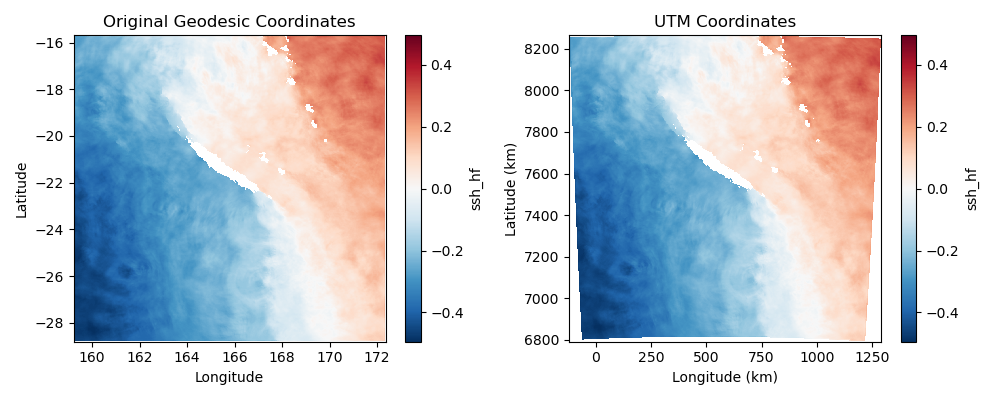

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot using original geodesic coordinates
ssh_hf_1h_masked.plot(ax=ax[0], x='lon', y='lat', add_colorbar=True)
ax[0].set_title('Original Geodesic Coordinates')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot using UTM coordinates
ssh_hf_1h_masked.plot(ax=ax[1], x='utm_x', y='utm_y', add_colorbar=True)
ax[1].set_title('UTM Coordinates')
ax[1].set_xlabel('Longitude (km)')
ax[1].set_ylabel('Latitude (km)')

plt.tight_layout()
plt.show()

In [40]:
dx = ssh_hf_1h_masked['lon'].diff(dim='x')  # Change in longitude along x-axis
dy = ssh_hf_1h_masked['lat'].diff(dim='y')  # Change in latitude along y-axis
dx_mean = float(dx.mean().values)  # Ensure this is a scalar float
dy_mean = float(dy.mean().values)  # Ensure this is a scalar float
delta_mean = float(np.mean([dx_mean, dy_mean]))  # Ensure this is a scalar float

print(f"dx (longitude): {dx_mean} deg")
print(f"dy (latitude): {dy_mean} deg")
print(f"Average delta: {delta_mean} deg")

dx (longitude): 0.016666647046804428 deg
dy (latitude): 0.015380489639937878 deg
Average delta: 0.016023568343371153 deg


In [41]:
dx = ssh_hf_1h_masked['utm_x'].diff(dim='x')  # Change in longitude along x-axis
dy = ssh_hf_1h_masked['utm_y'].diff(dim='y')  # Change in latitude along y-axis
dx_mean = float(dx.mean().values)  # Ensure this is a scalar float
dy_mean = float(dy.mean().values)  # Ensure this is a scalar float
delta_mean = float(np.mean([dx_mean, dy_mean]))  # Ensure this is a scalar float

print(f"dx (longitude): {dx_mean} deg")
print(f"dy (latitude): {dy_mean} deg")
print(f"Average delta: {delta_mean} deg")

dx (longitude): 1.7150764271819177 deg
dy (latitude): 1.7052837780145982 deg
Average delta: 1.710180102598258 deg


In [43]:
# Create a regular Cartesian grid with dx and dy = 1.7 km
dx, dy = 1.7, 1.7
x_min, x_max = x_km.min(), x_km.max()
y_min, y_max = y_km.min(), y_km.max()

# Define new grid
x_new = np.arange(x_min, x_max, dx)
y_new = np.arange(y_min, y_max, dy)
x_grid, y_grid = np.meshgrid(x_new, y_new)

# Interpolate to the new grid
data_interp = griddata((x_km.flatten(), y_km.flatten()), ssh_hf_1h_masked.values.flatten(), (x_grid, y_grid), method='cubic')

# Create new DataArray with regular grid
ssh_hf_regular = xr.DataArray(data_interp, coords=[y_new, x_new], dims=['y', 'x'])

In [45]:
ssh_hf_regular

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

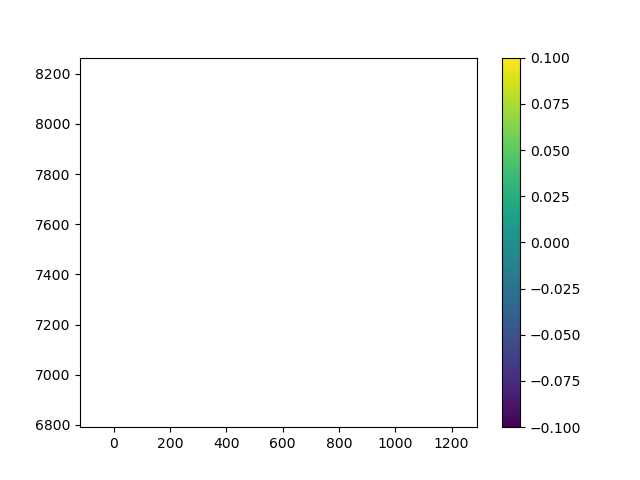

In [44]:
plt.figure()
plt.pcolormesh(x_grid, y_grid, ssh_hf_regular, shading='auto')
plt.colorbar()

Original x range: -118.79531027908135 to 1289.4107255304857
Original y range: 6791.458970917702 to 8264.27446257775


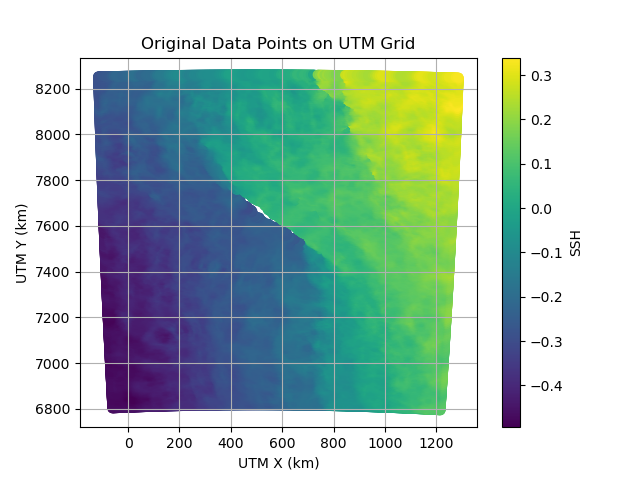

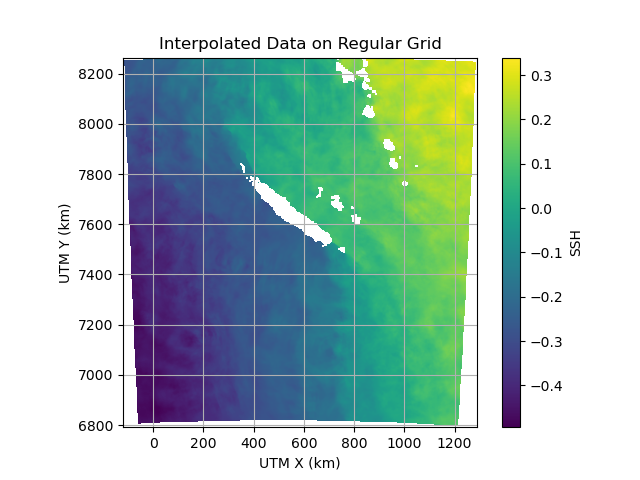

In [47]:
# Check the min and max of the original coordinates
print(f"Original x range: {x_km.min()} to {x_km.max()}")
print(f"Original y range: {y_km.min()} to {y_km.max()}")

# Plotting the original data to visualize coverage
plt.figure()
plt.scatter(x_km, y_km, c=ssh_hf_1h_masked.values.flatten(), cmap='viridis')
plt.colorbar(label='SSH')
plt.title('Original Data Points on UTM Grid')
plt.xlabel('UTM X (km)')
plt.ylabel('UTM Y (km)')
plt.grid(True)
plt.show()

# Define new grid within original data boundaries
x_new = np.arange(x_km.min(), x_km.max(), dx)
y_new = np.arange(y_km.min(), y_km.max(), dy)
x_grid, y_grid = np.meshgrid(x_new, y_new)

# Interpolate to the new grid using 'nearest' for more robust handling
data_interp = griddata(
    (x_km.flatten(), y_km.flatten()),
    ssh_hf_1h_masked.values.flatten(),
    (x_grid, y_grid),
    method='nearest'  # Changed to 'nearest' for robustness
)

# Create new DataArray with regular grid
ssh_hf_regular = xr.DataArray(data_interp, coords=[y_new, x_new], dims=['y', 'x'])

# Plot the interpolated data
plt.figure()
plt.imshow(ssh_hf_regular, origin='lower', extent=(x_new.min(), x_new.max(), y_new.min(), y_new.max()), cmap='viridis')
plt.colorbar(label='SSH')
plt.title('Interpolated Data on Regular Grid')
plt.xlabel('UTM X (km)')
plt.ylabel('UTM Y (km)')
plt.grid(True)
plt.show()

In [ ]:
# Otra forma pero sale al reves

import numpy as np
import xarray as xr
from pyresample.geometry import AreaDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest

# Load your DataArray, replace 'ssh_hf_1h_masked' with your actual data variable
da = ssh_hf_1h_masked

# Define the grid resolution in degrees (1 degree latitude ~ 111 km)
dx = dy = 1.7 / 111  # Convert km to degrees

# Generate latitude and longitude arrays ensuring they are in ascending order
lat_min, lat_max = float(da.lat.min()), float(da.lat.max())
lon_min, lon_max = float(da.lon.min()), float(da.lon.max())

# Create latitude and longitude arrays
new_lats = np.arange(lat_min, lat_max + dy, dy)
if new_lats[-1] > lat_max:
    new_lats = new_lats[:-1]  # Ensure the last latitude does not exceed the maximum

new_lons = np.arange(lon_min, lon_max + dx, dx)
if new_lons[-1] > lon_max:
    new_lons = new_lons[:-1]  # Ensure the last longitude does not exceed the maximum

# Define the target grid for the interpolation
target_def = AreaDefinition('target_area', 'Regular Grid', 'target',
                            {'proj': 'latlong', 'datum': 'WGS84'},
                            len(new_lons), len(new_lats),
                            [lon_min, lat_min, lon_max, lat_max])

# Flatten and mask the original data arrays
orig_lons = da.lon.values.flatten()
orig_lats = da.lat.values.flatten()
values = da.values.flatten()

valid_mask = ~np.isnan(values)  # Mask to ignore NaN values
data = values[valid_mask]
swath_lons = orig_lons[valid_mask]
swath_lats = orig_lats[valid_mask]

# Define the original grid as a swath for interpolation
swath_def = SwathDefinition(lons=swath_lons, lats=swath_lats)

# Perform the nearest neighbor interpolation
result = resample_nearest(swath_def, data, target_def, radius_of_influence=2700, fill_value=np.nan)

# Convert the result back into an xarray DataArray
interpolated_da = xr.DataArray(result, dims=['lat', 'lon'], coords={'lat': new_lats[::-1], 'lon': new_lons})

# If the data appears upside down, uncomment the following line to flip it:
# interpolated_da = interpolated_da.reindex(lat=interpolated_da.lat[::-1])

# Print or return the interpolated data array
print(interpolated_da)
